## Imports et Configuration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from itertools import combinations

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)
from collections import Counter

# Config
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

print("✅ Imports réussis")

/home/aboussif/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


✅ Imports réussis


---
# Chargement et Exploration des Données

On charge les deux datasets :
- **Positifs** : interactions connues (binders expérimentaux)
- **Négatifs** : non-interactions (design failures)

Puis on fusionne et on nettoie les données.

In [3]:
# Chemins des données
POS_PATH = Path("../src/data/positive_labeled_dataset_dG_SASA.csv")
NEG_PATH = Path("../src/data/negative_labeled_dataset_dG_SASA.csv")

# Charger
df_pos = pd.read_csv(POS_PATH)
df_neg = pd.read_csv(NEG_PATH)

# Assigner labels
df_pos["label"] = 1  # binder
df_neg["label"] = 0  # non-binder

# Fusionner
df = pd.concat([df_pos, df_neg], ignore_index=True)
df = df.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"✅ Dataset fusionné")
print(f"   Positifs (binders):     {(df['label']==1).sum()}")
print(f"   Négatifs (non-binders): {(df['label']==0).sum()}")
print(f"   Total:                  {len(df)}")
print(f"\n   Shape: {df.shape}")
print(f"\n   Colonnes:\n   {df.columns.tolist()}")

✅ Dataset fusionné
   Positifs (binders):     195
   Négatifs (non-binders): 200
   Total:                  395

   Shape: (395, 10)

   Colonnes:
   ['id', 'ipsae', 'pdockq2', 'prodigy_kd', 'ipTM+pTM', 'dG_SASA_ratio', 'prodigy_dg_internal', 'ipTM', 'dG_rosetta', 'label']


In [4]:
# Nettoyer les colonnes numériques (virgule -> point)
FEATURE_COLS = [
    "ipsae", "pdockq2", "prodigy_kd", "ipTM+pTM", 
    "dG_SASA_ratio", "prodigy_dg_internal", "ipTM", "dG_rosetta"
]

for col in FEATURE_COLS:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .replace(["nan", "NaN", ""], np.nan)
        .astype(float)
    )

# Enlever les NaN
df_clean = df.dropna(subset=FEATURE_COLS + ["label"]).copy()

X = df_clean[FEATURE_COLS].values
y = df_clean["label"].values

print(f"   Shape finale: {X.shape}")
print(f"   Features: {len(FEATURE_COLS)}")
print(f"   Exemples valides: {len(df_clean)}")

   Shape finale: (391, 8)
   Features: 8
   Exemples valides: 391


In [5]:
# Statistiques descriptives
print("\n=== Statistiques Descriptives ===")
print(df_clean[FEATURE_COLS + ["label"]].describe())

# Répartition par classe
print("\n=== Distribution des classes ===")
for i, col in enumerate(FEATURE_COLS):
    pos_mean = df_clean[df_clean["label"]==1][col].mean()
    neg_mean = df_clean[df_clean["label"]==0][col].mean()
    print(f"{col:20s} | Pos: {pos_mean:8.3f} | Neg: {neg_mean:8.3f}")


=== Statistiques Descriptives ===
            ipsae     pdockq2    prodigy_kd    ipTM+pTM  dG_SASA_ratio  \
count  391.000000  391.000000  3.910000e+02  391.000000     391.000000   
mean     0.372130    0.333323  3.711100e-05    0.577528       2.035089   
std      0.398156    0.325243  2.759498e-04    0.297259       3.084827   
min      0.000000    0.000000  4.131770e-28    0.165925      -0.046140   
25%      0.000000    0.009300  6.486400e-10    0.277246       0.001084   
50%      0.066708    0.167900  5.234992e-08    0.477517       0.552769   
75%      0.828210    0.677300  1.174221e-06    0.901302       2.944248   
max      0.947993    0.839900  4.512831e-03    0.965239      20.022456   

       prodigy_dg_internal        ipTM    dG_rosetta       label  
count           391.000000  391.000000    391.000000  391.000000  
mean            -10.687045    0.532405   3222.184343    0.496164  
std               4.068699    0.337230   5400.930289    0.500626  
min             -37.333412    

---
## TRAIN/TEST SPLIT

**Éviter toute fuite de données (data leakage)**

**Avant toute évaluation de modèle**:
- Split Train/Test en 80/20 avec stratification.
- Toute la sélection de modèles et l’ingénierie de features est effectuée uniquement sur le jeu d’entraînement
- Le jeu de test est totalement mis de côté et n’est jamais utilisé pour:
  - l’évaluation univariée des features
  - la sélection gloutonne (greedy) des features
  - la génération ou l’évaluation des features d’interaction
- L’évaluation finale est réalisée uniquement sur le jeu de test, avec les modèles entraînés sur le train

In [6]:
# TRAIN/VALIDATION/TEST SPLIT - STRATIFIED, 70/10/20
from sklearn.model_selection import train_test_split

# First split: 80% train+val / 20% test
# Keep track of indices
temp_indices, test_indices = train_test_split(
    np.arange(len(X)), 
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

X_temp = X[temp_indices]
y_temp = y[temp_indices]
X_test = X[test_indices]
y_test = y[test_indices]

# Second split: split the 80% into 70% train / 10% val
# 10/80 = 0.125
train_indices_relative, val_indices_relative = train_test_split(
    np.arange(len(X_temp)), 
    test_size=0.125,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

# Convert back to original indices in df_clean
train_indices = temp_indices[train_indices_relative]
val_indices = temp_indices[val_indices_relative]

X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]

print("TRAIN/VALIDATION/TEST SPLIT (Stratified 70/10/20)")
print(f"\nTRAIN SET ({len(X_train)} samples - 70%):")
print(f"   Positives (label=1): {(y_train==1).sum()}")
print(f"   Negatives (label=0): {(y_train==0).sum()}")
print(f"   Ratio: {(y_train==1).sum() / len(y_train) * 100:.1f}% binders")

print(f"\nVALIDATION SET ({len(X_val)} samples - 10%):")
print(f"   Positives (label=1): {(y_val==1).sum()}")
print(f"   Negatives (label=0): {(y_val==0).sum()}")
print(f"   Ratio: {(y_val==1).sum() / len(y_val) * 100:.1f}% binders")

print(f"\nTEST SET ({len(X_test)} samples - 20%):")
print(f"   Positives (label=1): {(y_test==1).sum()}")
print(f"   Negatives (label=0): {(y_test==0).sum()}")
print(f"   Ratio: {(y_test==1).sum() / len(y_test) * 100:.1f}% binders")

print(f"\n✓ Indices tracked:")
print(f"  - train_indices: {len(train_indices)} samples")
print(f"  - val_indices: {len(val_indices)} samples")
print(f"  - test_indices: {len(test_indices)} samples")
print(f"  - No overlap: {len(set(train_indices) & set(val_indices) & set(test_indices)) == 0}")

print(f"\n✓ Validation set is used for:")
print(f"  - Feature selection")
print(f"  - Model training/hyperparameter tuning")
print(f"✓ Test set is held-out and will ONLY be used for final evaluation")


TRAIN/VALIDATION/TEST SPLIT (Stratified 70/10/20)

TRAIN SET (273 samples - 70%):
   Positives (label=1): 136
   Negatives (label=0): 137
   Ratio: 49.8% binders

VALIDATION SET (39 samples - 10%):
   Positives (label=1): 19
   Negatives (label=0): 20
   Ratio: 48.7% binders

TEST SET (79 samples - 20%):
   Positives (label=1): 39
   Negatives (label=0): 40
   Ratio: 49.4% binders

✓ Indices tracked:
  - train_indices: 273 samples
  - val_indices: 39 samples
  - test_indices: 79 samples
  - No overlap: True

✓ Validation set is used for:
  - Feature selection
  - Model training/hyperparameter tuning
✓ Test set is held-out and will ONLY be used for final evaluation


---
# EXPLORATORY DATA ANALYSIS (on TRAIN set only)

- Feature distributions (histograms)
- Feature correlations (heatmap)
- Class-wise differences
- Outliers and missing patterns

In [7]:
# Create DataFrames for EDA using the true split indices
df_train = df_clean.iloc[train_indices].copy()
df_val = df_clean.iloc[val_indices].copy()
df_test = df_clean.iloc[test_indices].copy()

print(f"✅ EDA DataFrames created using TRUE split indices")
print(f"   df_train shape: {df_train.shape}")
print(f"   df_val shape: {df_val.shape}")
print(f"   df_test shape: {df_test.shape}")


✅ EDA DataFrames created using TRUE split indices
   df_train shape: (273, 10)
   df_val shape: (39, 10)
   df_test shape: (79, 10)


In [8]:
# Descriptive statistics by class
print("\n" + "="*70)
print("DESCRIPTIVE STATISTICS (TRAIN SET)")
print("="*70)

print("\n📊 BINDERS (label=1):")
print(df_train[df_train["label"]==1][FEATURE_COLS].describe().round(3))

print("\n📊 NON-BINDERS (label=0):")
print(df_train[df_train["label"]==0][FEATURE_COLS].describe().round(3))

print("\n📊 DIFFERENCE (Binders - Non-binders):")
diff_stats = df_train[df_train["label"]==1][FEATURE_COLS].mean() - df_train[df_train["label"]==0][FEATURE_COLS].mean()
for col, val in diff_stats.items():
    print(f"   {col:20s}: {val:+8.4f}")



DESCRIPTIVE STATISTICS (TRAIN SET)

📊 BINDERS (label=1):
         ipsae  pdockq2  prodigy_kd  ipTM+pTM  dG_SASA_ratio  \
count  136.000  136.000     136.000   136.000        136.000   
mean     0.725    0.620       0.000     0.835          0.416   
std      0.265    0.206       0.000     0.180          1.404   
min      0.000    0.000       0.000     0.166         -0.046   
25%      0.684    0.591       0.000     0.841         -0.018   
50%      0.840    0.679       0.000     0.906          0.001   
75%      0.889    0.745       0.000     0.930          0.090   
max      0.948    0.840       0.001     0.965         11.064   

       prodigy_dg_internal     ipTM  dG_rosetta  
count              136.000  136.000     136.000  
mean               -12.361    0.827     905.898  
std                  4.887    0.198    3245.750  
min                -37.333    0.088    -245.318  
25%                -14.483    0.841     -45.776  
50%                -11.321    0.903       3.684  
75%            

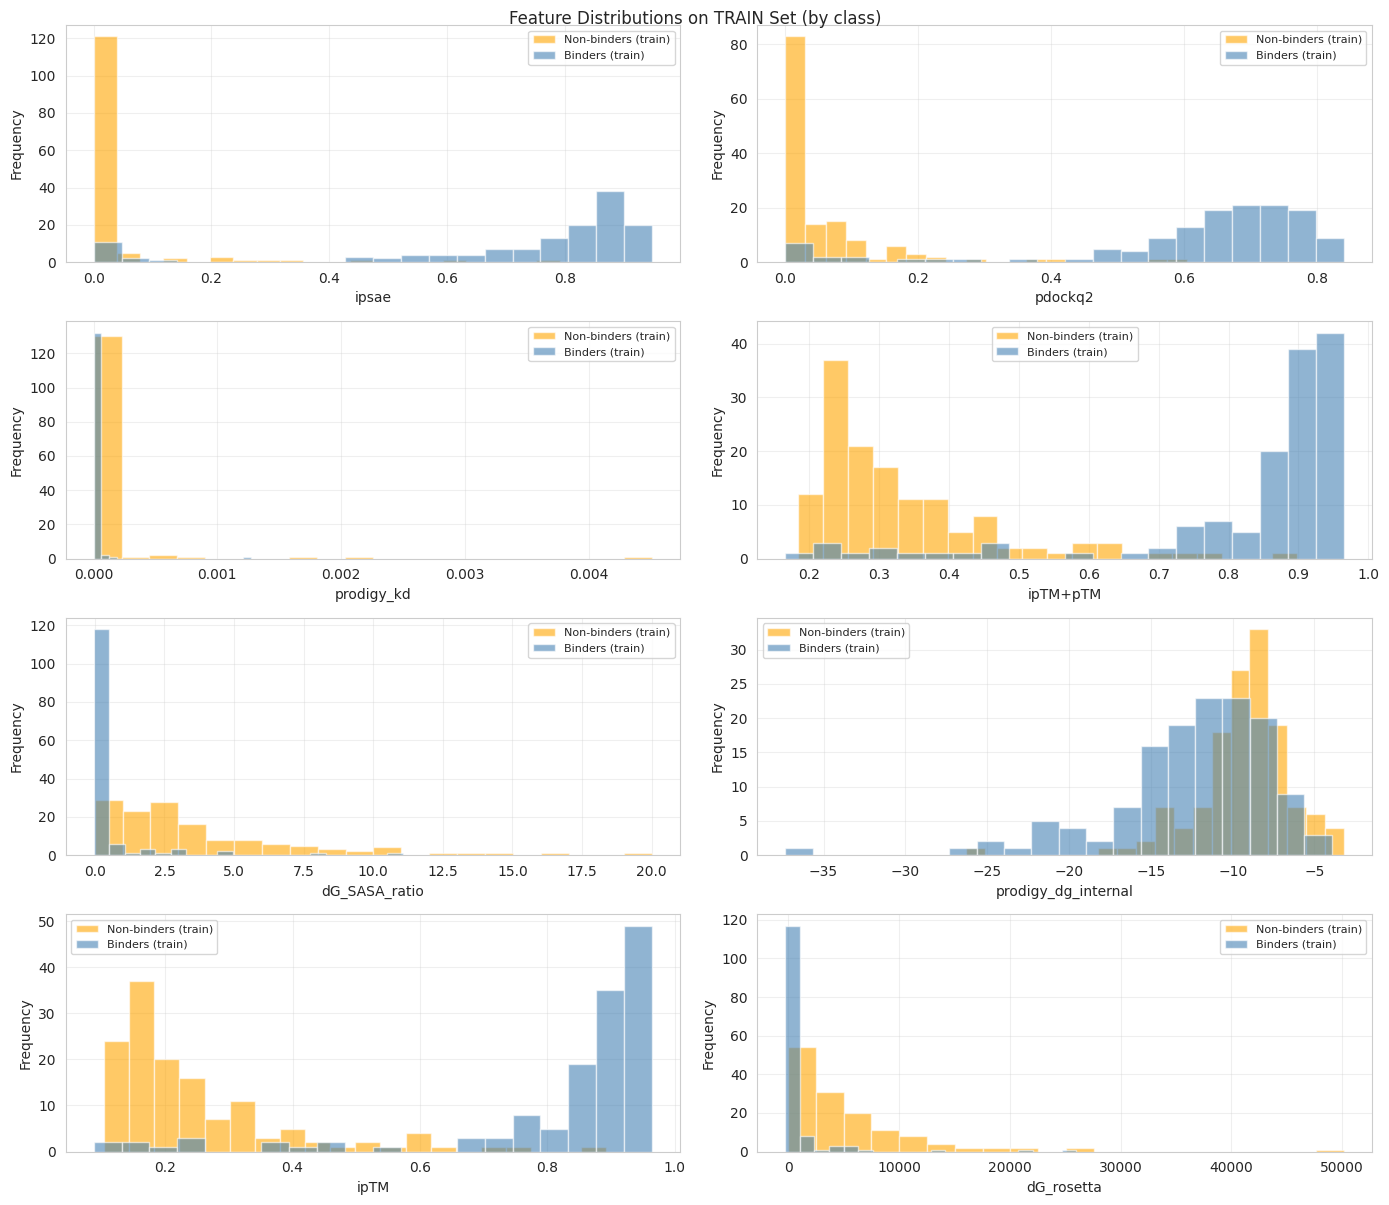

In [9]:
# Distributions and class separation
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, col in enumerate(FEATURE_COLS):
    ax = axes[idx]
    
    train_pos = df_train[df_train["label"]==1][col]
    train_neg = df_train[df_train["label"]==0][col]
    
    ax.hist(train_neg, bins=20, alpha=0.6, label='Non-binders (train)', color='orange')
    ax.hist(train_pos, bins=20, alpha=0.6, label='Binders (train)', color='steelblue')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Feature Distributions on TRAIN Set (by class)', y=1.00)
plt.show()



            Feature  Lower_bound  Upper_bound  Nb_outliers  Outliers_label_0  Outliers_label_1  Pct_outliers
         prodigy_kd    -0.000002     0.000003           49                32                17      0.179487
      dG_SASA_ratio    -4.334427     7.223645           20                18                 2      0.073260
         dG_rosetta -6650.789734 11083.861340           20                17                 3      0.073260
prodigy_dg_internal   -19.409658    -1.396944           14                 1                13      0.051282
              ipsae    -1.259652     2.099420            0                 0                 0      0.000000
            pdockq2    -0.986000     1.678000            0                 0                 0      0.000000
           ipTM+pTM    -0.661183     1.846550            0                 0                 0      0.000000
               ipTM    -0.881152     1.971572            0                 0                 0      0.000000


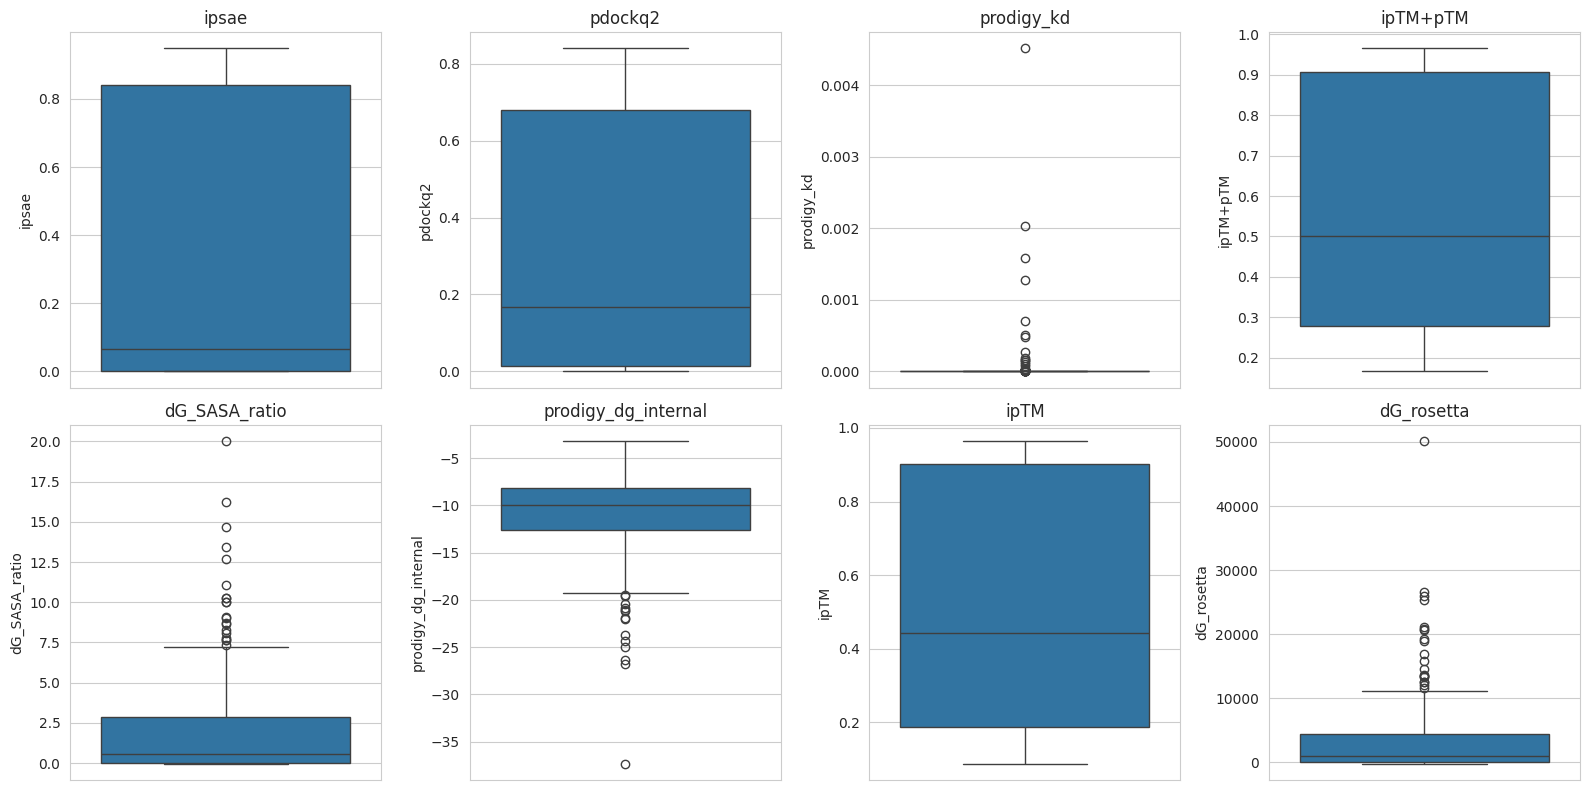

In [41]:
# === Outlier detection (TRAIN only) ===

outlier_info = []

for col in FEATURE_COLS:
    x = df_train[col].dropna()
    
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Identify outliers
    mask_outliers = (df_train[col] < lower) | (df_train[col] > upper)
    n_outliers = mask_outliers.sum()
    
    # Count outliers by label
    n_outliers_label_0 = ((df_train[col] < lower) | (df_train[col] > upper)) & (df_train['label'] == 0)
    n_outliers_label_1 = ((df_train[col] < lower) | (df_train[col] > upper)) & (df_train['label'] == 1)
    
    outlier_info.append({
        "Feature": col,
        "Lower_bound": lower,
        "Upper_bound": upper,
        "Nb_outliers": n_outliers,
        "Outliers_label_0": n_outliers_label_0.sum(),
        "Outliers_label_1": n_outliers_label_1.sum(),
        "Pct_outliers": n_outliers / len(x)
    })

df_outliers = pd.DataFrame(outlier_info).sort_values("Pct_outliers", ascending=False)
print(df_outliers.to_string(index=False))

# Plot a boxplot grid for visual inspection
import seaborn as sns
n_cols = 4
n_rows = int(np.ceil(len(FEATURE_COLS) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.ravel()

for ax, col in zip(axes, FEATURE_COLS):
    sns.boxplot(
        data=df_train,
        y=col,
        ax=ax
    )
    ax.set_title(col)

for j in range(len(FEATURE_COLS), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


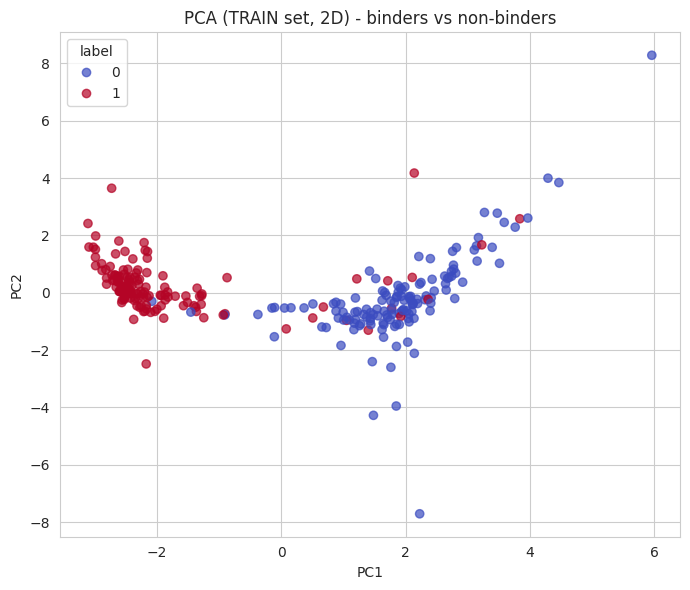

Explained variance ratio: [0.61307262 0.20113   ]


In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# optionnel : 
# !pip install umap-learn
# import umap

# On prend uniquement les features, TRAIN set
X_train_eda = df_train[FEATURE_COLS].values
y_train_eda = df_train["label"].values

# Standardisation
scaler_eda = StandardScaler()
X_train_scaled = scaler_eda.fit_transform(X_train_eda)

# PCA 2D
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_train_scaled)

fig, ax = plt.subplots(figsize=(7, 6))
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=y_train_eda,
    cmap="coolwarm",
    alpha=0.7
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA (TRAIN set, 2D) - binders vs non-binders")
plt.legend(*scatter.legend_elements(), title="label")
plt.tight_layout()
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


In [ ]:
from scipy.stats import mannwhitneyu
import statsmodels.stats.multitest as smm 

results = []

for col in FEATURE_COLS:
    pos = df_train[df_train["label"] == 1][col].dropna().values
    neg = df_train[df_train["label"] == 0][col].dropna().values
    
    if len(pos) == 0 or len(neg) == 0:
        continue  # sécurité
    
    # Mann–Whitney U test (two-sided)
    u_stat, p_val = mannwhitneyu(pos, neg, alternative="two-sided")
    
    # Effet de taille : rank-biserial correlation
    n1, n2 = len(pos), len(neg)
    rbc = 2 * u_stat / (n1 * n2) - 1  # entre -1 et 1
    
    results.append({
        "Feature": col,
        "U_stat": u_stat,
        "p_value": p_val,
        "Rank-biserial_effect_size": rbc,
        "Mean_pos": pos.mean(),
        "Mean_neg": neg.mean(),
        "Median_pos": np.median(pos),
        "Median_neg": np.median(neg),
    })

df_stats = pd.DataFrame(results)

# Correction de Benjamini–Hochberg (FDR)
pvals = df_stats["p_value"].values
rejected, pvals_corr, _, _ = smm.multipletests(pvals, alpha=0.05, method="fdr_bh")
df_stats["p_value_FDR"] = pvals_corr
df_stats["Significant_FDR_0.05"] = rejected

# Trier par p-value corrigée ou effet de taille absolu
df_stats = df_stats.sort_values("p_value_FDR")

print("=== Mann–Whitney U tests (TRAIN set, 1 vs 0) ===")
print(df_stats.to_string(index=False))


=== Mann–Whitney U tests (TRAIN set, 1 vs 0) ===
            Feature  U_stat      p_value  Rank-biserial_effect_size   Mean_pos    Mean_neg    Median_pos    Median_neg  p_value_FDR  Significant_FDR_0.05
              ipsae 17789.0 9.991338e-40                   0.909511   0.725498    0.032704  8.401260e-01  0.000000e+00 7.993070e-39                  True
            pdockq2 17802.5 4.687875e-39                   0.910960   0.619753    0.053894  6.790000e-01  1.670000e-02 1.875150e-38                  True
               ipTM 17786.0 1.487555e-38                   0.909188   0.826779    0.246593  9.026115e-01  1.954239e-01 3.966814e-38                  True
           ipTM+pTM 17709.0 6.904086e-38                   0.900923   0.834662    0.328316  9.063116e-01  2.904511e-01 1.380817e-37                  True
      dG_SASA_ratio  1444.0 1.554666e-33                  -0.844998   0.415640    3.599114  9.505368e-04  2.695219e+00 2.487466e-33                  True
         dG_rosetta  1897.0

In [13]:
def p_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

df_stats["Signif_stars_FDR"] = df_stats["p_value_FDR"].apply(p_to_stars)

print("=== Mann–Whitney U tests (TRAIN set, 1 vs 0, with FDR) ===")
print(df_stats.to_string(index=False))


=== Mann–Whitney U tests (TRAIN set, 1 vs 0, with FDR) ===
            Feature  U_stat      p_value  Rank-biserial_effect_size   Mean_pos    Mean_neg    Median_pos    Median_neg  p_value_FDR  Significant_FDR_0.05 Signif_stars_FDR
              ipsae 17789.0 9.991338e-40                   0.909511   0.725498    0.032704  8.401260e-01  0.000000e+00 7.993070e-39                  True              ***
            pdockq2 17802.5 4.687875e-39                   0.910960   0.619753    0.053894  6.790000e-01  1.670000e-02 1.875150e-38                  True              ***
               ipTM 17786.0 1.487555e-38                   0.909188   0.826779    0.246593  9.026115e-01  1.954239e-01 3.966814e-38                  True              ***
           ipTM+pTM 17709.0 6.904086e-38                   0.900923   0.834662    0.328316  9.063116e-01  2.904511e-01 1.380817e-37                  True              ***
      dG_SASA_ratio  1444.0 1.554666e-33                  -0.844998   0.415640    3.59

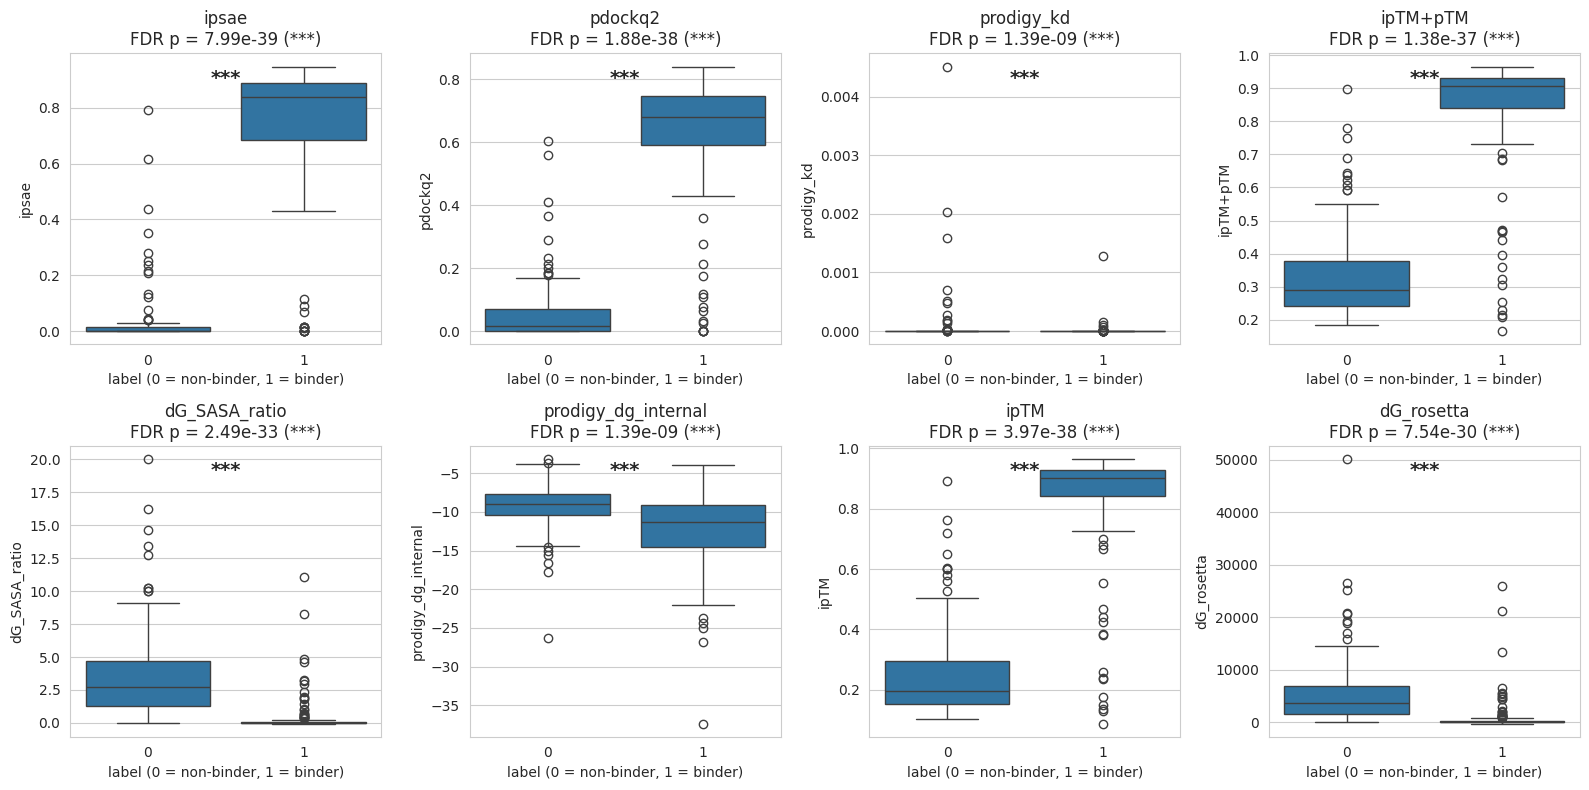

In [44]:
# On prépare un dict pour retrouver rapidement les stats d'une feature
stats_by_feat = df_stats.set_index("Feature")

n_features = len(FEATURE_COLS)
n_cols = 4  # adapte si besoin
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), squeeze=False)
axes = axes.ravel()

for ax, col in zip(axes, FEATURE_COLS):
    # Boxplot binders vs non-binders sur TRAIN
    sns.boxplot(
        data=df_train,
        x="label",
        y=col,
        ax=ax
    )
    
    ax.set_xlabel("label (0 = non-binder, 1 = binder)")
    ax.set_ylabel(col)
    
    # Récupérer p_FDR et étoiles pour cette feature
    if col in stats_by_feat.index:
        p_fdr = stats_by_feat.loc[col, "p_value_FDR"]
        stars = stats_by_feat.loc[col, "Signif_stars_FDR"]
        
        # Titre avec p_FDR
        ax.set_title(f"{col}\nFDR p = {p_fdr:.2e} ({stars})")
        
        # Position de l'annotation
        y_min = df_train[col].min()
        y_max = df_train[col].max()
        y_range = y_max - y_min
        
        # On place les étoiles au-dessus des boxplots
        ax.text(
            0.5,                           # au milieu entre 0 et 1 sur l'axe x
            y_max - 0.08 * y_range,        # un peu au-dessus du max
            stars,
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="bold"
        )
    else:
        ax.set_title(col + "\n(no stats)")

# Enlever les axes vides si n_features < n_rows * n_cols
for j in range(len(FEATURE_COLS), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


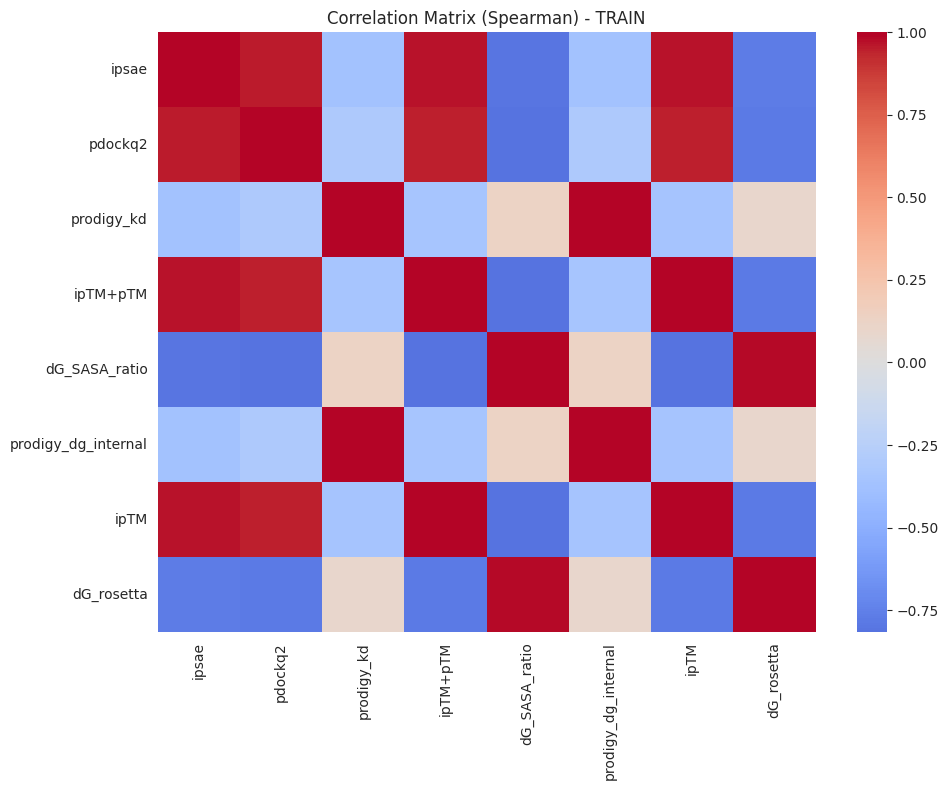

In [14]:
# Spearman (rang, non-paramétrique — robuste à non-normalité et monotone)
correlation_spearman = df_train[FEATURE_COLS].corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_spearman, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Spearman) - TRAIN')
plt.tight_layout()
plt.show()

In [16]:
from sklearn.utils import resample

n_boot = 1000
rng = np.random.default_rng(RANDOM_STATE)

bootstrap_results = []

for col in FEATURE_COLS:
    pos = df_train[df_train["label"] == 1][col].dropna().values
    neg = df_train[df_train["label"] == 0][col].dropna().values
    
    if len(pos) == 0 or len(neg) == 0:
        continue
    
    # Observed statistics
    med_diff_obs = np.median(pos) - np.median(neg)
    
    # rank-biserial effect size
    u_stat, _ = mannwhitneyu(pos, neg, alternative="two-sided")
    rbc_obs = 2 * u_stat / (len(pos)*len(neg)) - 1
    
    # Bootstrap sampling
    med_diffs = []
    rbc_vals = []
    
    for _ in range(n_boot):
        pos_bs = rng.choice(pos, size=len(pos), replace=True)
        neg_bs = rng.choice(neg, size=len(neg), replace=True)
        
        # Median difference
        med_diffs.append(np.median(pos_bs) - np.median(neg_bs))
        
        # Rank-biserial scaled U-stat
        u_bs, _ = mannwhitneyu(pos_bs, neg_bs, alternative="two-sided")
        rbc_vals.append(2 * u_bs / (len(pos_bs)*len(neg_bs)) - 1)
    
    # Confidence intervals
    med_CI = np.percentile(med_diffs, [2.5, 97.5])
    rbc_CI = np.percentile(rbc_vals, [2.5, 97.5])
    
    bootstrap_results.append({
        "Feature": col,
        "Median_diff_obs": med_diff_obs,
        "Median_diff_CI_low": med_CI[0],
        "Median_diff_CI_high": med_CI[1],
        "Rank_biserial_obs": rbc_obs,
        "Rank_biserial_CI_low": rbc_CI[0],
        "Rank_biserial_CI_high": rbc_CI[1],
    })

df_boot = pd.DataFrame(bootstrap_results).sort_values("Median_diff_obs", key=abs, ascending=False)
print(df_boot.to_string(index=False))


            Feature  Median_diff_obs  Median_diff_CI_low  Median_diff_CI_high  Rank_biserial_obs  Rank_biserial_CI_low  Rank_biserial_CI_high
         dG_rosetta    -3.609854e+03       -4.500877e+03        -2.760256e+03          -0.796372             -0.867542              -0.716705
      dG_SASA_ratio    -2.694269e+00       -2.992882e+00        -2.328869e+00          -0.844998             -0.905649              -0.771989
prodigy_dg_internal    -2.377737e+00       -3.547026e+00        -1.463507e+00          -0.424109             -0.545993              -0.302582
              ipsae     8.401260e-01        8.033588e-01         8.588510e-01           0.909511              0.855892               0.957655
               ipTM     7.071876e-01        6.784917e-01         7.279184e-01           0.909188              0.851436               0.963292
            pdockq2     6.623000e-01        6.394988e-01         6.906575e-01           0.910960              0.850523               0.962326
      

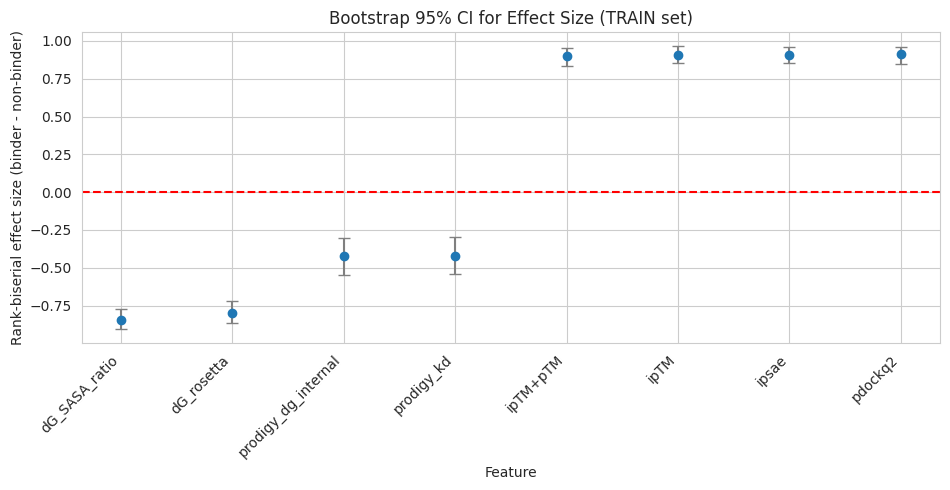

In [17]:
df_boot_effect = df_boot.sort_values("Rank_biserial_obs")

fig, ax = plt.subplots(figsize=(len(df_boot_effect) * 1.2, 5))

ax.errorbar(
    df_boot_effect["Feature"],
    df_boot_effect["Rank_biserial_obs"],
    yerr=[
        df_boot_effect["Rank_biserial_obs"] - df_boot_effect["Rank_biserial_CI_low"],
        df_boot_effect["Rank_biserial_CI_high"] - df_boot_effect["Rank_biserial_obs"]
    ],
    fmt='o',
    ecolor='gray',
    capsize=4
)

ax.axhline(0, color='red', linestyle='--')

ax.set_ylabel("Rank-biserial effect size (binder - non-binder)")
ax.set_xlabel("Feature")
ax.set_title("Bootstrap 95% CI for Effect Size (TRAIN set)")

# Pour éviter le chevauchement des labels
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


### Explication de la Figure 3 du papier

Le papier (Figure 3A-D) teste **chaque métrique individuellement** pour identifier les meilleurs prédicteurs de liaison.

**Logique du papier** :
- Pour chaque feature, calculer sa capacité à séparer les binders des non-binders
- Utiliser Average Precision (AP) comme métrique principale (robuste au déséquilibre de classes ~12% binders dans leur dataset ici ~50%)
- Reporter aussi ROC AUC pour comparaison
- Identifier les meilleurs prédicteurs isolés

**Notre implémentation** :
- Train univarié sur l'ensemble TRAIN (70% des données)
- Normalisation avec StandardScaler
- Régression logistique simple pour chaque feature (univariée)
- Calcul de ROC AUC et AP sur VAL pour résultats non-biaisés

In [18]:
# Univariate evaluation: TRAIN on train set, EVALUATE on val set
univariate_scores = []

for col in FEATURE_COLS:
    x_train_col = X_train[:, FEATURE_COLS.index(col)]
    x_val_col = X_val[:, FEATURE_COLS.index(col)]
    
    # Fit scaler on TRAIN set only
    scaler_tmp = StandardScaler()
    x_train_scaled = scaler_tmp.fit_transform(x_train_col.reshape(-1, 1)).ravel()
    # Transform validation set using train set fitted scaler
    x_val_scaled = scaler_tmp.transform(x_val_col.reshape(-1, 1)).ravel()
    
    # Train univariate logistic regression on TRAIN set
    lr_uni = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=2000,
        random_state=RANDOM_STATE,
    )
    lr_uni.fit(x_train_scaled.reshape(-1, 1), y_train)
    
    # Evaluate on VALIDATION set ONLY
    y_proba_val = lr_uni.predict_proba(x_val_scaled.reshape(-1, 1))[:, 1]
    
    auc = roc_auc_score(y_val, y_proba_val)
    ap = average_precision_score(y_val, y_proba_val)
    
    univariate_scores.append({
        "Feature": col,
        "ROC AUC (VAL)": auc,
        "AP (VAL)": ap,
        "Coefficient": lr_uni.coef_[0][0]
    })

df_univariate = pd.DataFrame(univariate_scores).sort_values("AP (VAL)", ascending=False)
print("\n=== Évaluation Univariée des Features ===")
print("(Trained on TRAIN set, Evaluated on VALIDATION set)")
print(df_univariate.to_string(index=False))


=== Évaluation Univariée des Features ===
(Trained on TRAIN set, Evaluated on VALIDATION set)
            Feature  ROC AUC (VAL)  AP (VAL)  Coefficient
              ipsae       1.000000  1.000000     3.086482
            pdockq2       1.000000  1.000000     3.138372
               ipTM       0.994737  0.994987     2.891754
           ipTM+pTM       0.992105  0.992823     2.838705
      dG_SASA_ratio       0.952632  0.955017    -2.847941
         dG_rosetta       0.950000  0.947115    -2.174955
         prodigy_kd       0.555263  0.571313    -0.342481
prodigy_dg_internal       0.555263  0.571313    -0.943076


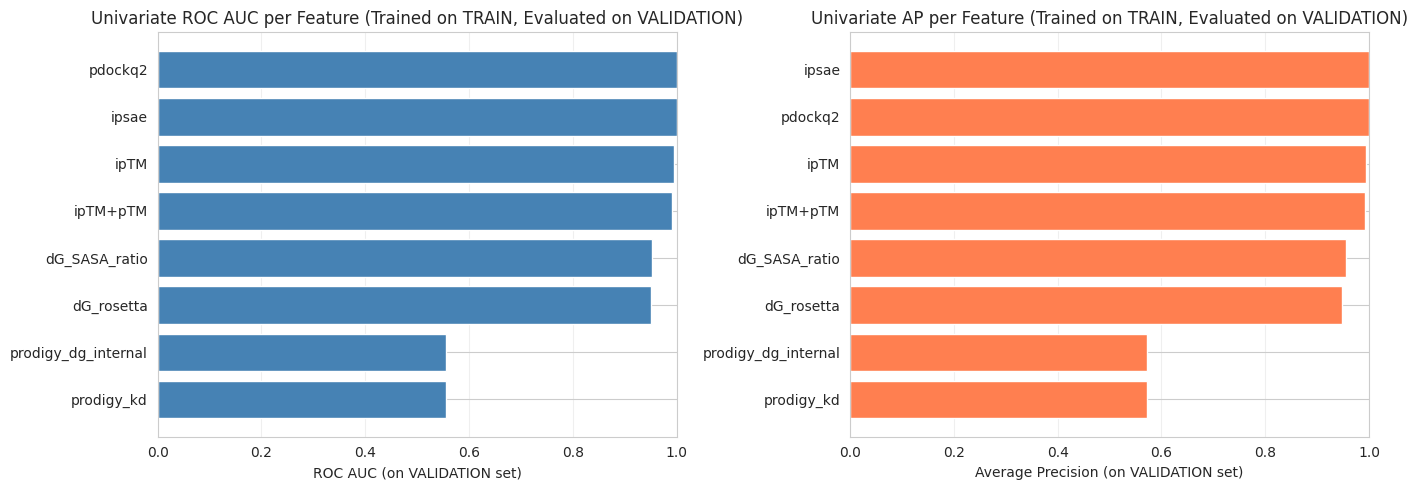


Top feature (on VALIDATION): ipsae (AP=1.0000)


In [19]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC AUC
df_plot = df_univariate.sort_values("ROC AUC (VAL)", ascending=True)
axes[0].barh(df_plot["Feature"], df_plot["ROC AUC (VAL)"], color="steelblue")
axes[0].set_xlabel("ROC AUC (on VALIDATION set)")
axes[0].set_title("Univariate ROC AUC per Feature (Trained on TRAIN, Evaluated on VALIDATION)")
axes[0].grid(alpha=0.3, axis='x')

# Average Precision
df_plot = df_univariate.sort_values("AP (VAL)", ascending=True)
axes[1].barh(df_plot["Feature"], df_plot["AP (VAL)"], color="coral")
axes[1].set_xlabel("Average Precision (on VALIDATION set)")
axes[1].set_title("Univariate AP per Feature (Trained on TRAIN, Evaluated on VALIDATION)")
axes[0].set_xlim(0.0, 1.0)
axes[1].set_xlim(0.0, 1.0)

axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nTop feature (on VALIDATION): {df_univariate.iloc[0]['Feature']} (AP={df_univariate.iloc[0]['AP (VAL)']:.4f})")

In [20]:
print("\n" + "="*70)
print("ROBUST UNIVARIATE ANALYSIS (CV on TRAIN + Bootstrap on VAL)")
print("="*70)

n_splits = 5
n_boot = 1000
rng = np.random.default_rng(RANDOM_STATE)

univariate_results = []

for col in FEATURE_COLS:
    
    # ---------
    # 1) CV interne sur TRAIN pour stabilité
    # ---------
    auc_cv = []
    ap_cv = []
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    for train_idx, test_idx in skf.split(X_train, y_train):
        x_tr = X_train[train_idx][:, FEATURE_COLS.index(col)].reshape(-1, 1)
        y_tr = y_train[train_idx]
        
        x_te = X_train[test_idx][:, FEATURE_COLS.index(col)].reshape(-1, 1)
        y_te = y_train[test_idx]
        
        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_te_s = scaler.transform(x_te)
        
        lr = LogisticRegression(
            penalty="l1",
            solver="liblinear",
            class_weight="balanced",
            max_iter=2000,
            random_state=RANDOM_STATE
        )
        lr.fit(x_tr_s, y_tr)
        
        y_proba_cv = lr.predict_proba(x_te_s)[:, 1]
        
        auc_cv.append(roc_auc_score(y_te, y_proba_cv))
        ap_cv.append(average_precision_score(y_te, y_proba_cv))
    
    
    # ---------
    # 2) Bootstrap sur VALIDATION
    # ---------
    auc_boot = []
    ap_boot = []
    
    x_train_col = X_train[:, FEATURE_COLS.index(col)].reshape(-1,1)
    x_val_col   = X_val[:, FEATURE_COLS.index(col)].reshape(-1,1)

    scaler = StandardScaler().fit(x_train_col)
    x_train_scaled = scaler.transform(x_train_col)
    x_val_scaled   = scaler.transform(x_val_col)

    lr_final = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=2000,
        random_state=RANDOM_STATE
    )
    lr_final.fit(x_train_scaled, y_train)

    y_proba_val = lr_final.predict_proba(x_val_scaled)[:,1]

    for _ in range(n_boot):
        idx = rng.integers(0, len(y_val), len(y_val))
        auc_boot.append(roc_auc_score(y_val[idx], y_proba_val[idx]))
        ap_boot.append(average_precision_score(y_val[idx], y_proba_val[idx]))

    def ci95(x): return np.percentile(x, [2.5, 95.5])
    
    univariate_results.append({
        "Feature": col,
        "AUC_CV_mean": np.mean(auc_cv),
        "AUC_CV_std": np.std(auc_cv),
        "AUC_VAL": roc_auc_score(y_val, y_proba_val),
        "AUC_VAL_CI_low": ci95(auc_boot)[0],
        "AUC_VAL_CI_high": ci95(auc_boot)[1],
        
        "AP_CV_mean": np.mean(ap_cv),
        "AP_CV_std": np.std(ap_cv),
        "AP_VAL": average_precision_score(y_val, y_proba_val),
        "AP_VAL_CI_low": ci95(ap_boot)[0],
        "AP_VAL_CI_high": ci95(ap_boot)[1],
        
        "Coefficient": lr_final.coef_[0][0],
    })

df_uni = pd.DataFrame(univariate_results).sort_values("AP_VAL", ascending=False)
print(df_uni.to_string(index=False))



ROBUST UNIVARIATE ANALYSIS (CV on TRAIN + Bootstrap on VAL)


            Feature  AUC_CV_mean  AUC_CV_std  AUC_VAL  AUC_VAL_CI_low  AUC_VAL_CI_high  AP_CV_mean  AP_CV_std   AP_VAL  AP_VAL_CI_low  AP_VAL_CI_high  Coefficient
              ipsae     0.951690    0.011064 1.000000        1.000000         1.000000    0.961651   0.008781 1.000000       1.000000        1.000000     3.086482
            pdockq2     0.952846    0.014058 1.000000        1.000000         1.000000    0.965992   0.009180 1.000000       1.000000        1.000000     3.138372
               ipTM     0.952675    0.015303 0.994737        0.973538         1.000000    0.967227   0.012047 0.994987       0.975709        1.000000     2.891754
           ipTM+pTM     0.946286    0.019931 0.992105        0.966643         1.000000    0.963768   0.013352 0.992823       0.967914        1.000000     2.838705
      dG_SASA_ratio     0.923888    0.019860 0.952632        0.884211         0.994709    0.940330   0.020309 0.955017       0.881104        0.995868    -2.847941
         dG_rosetta   

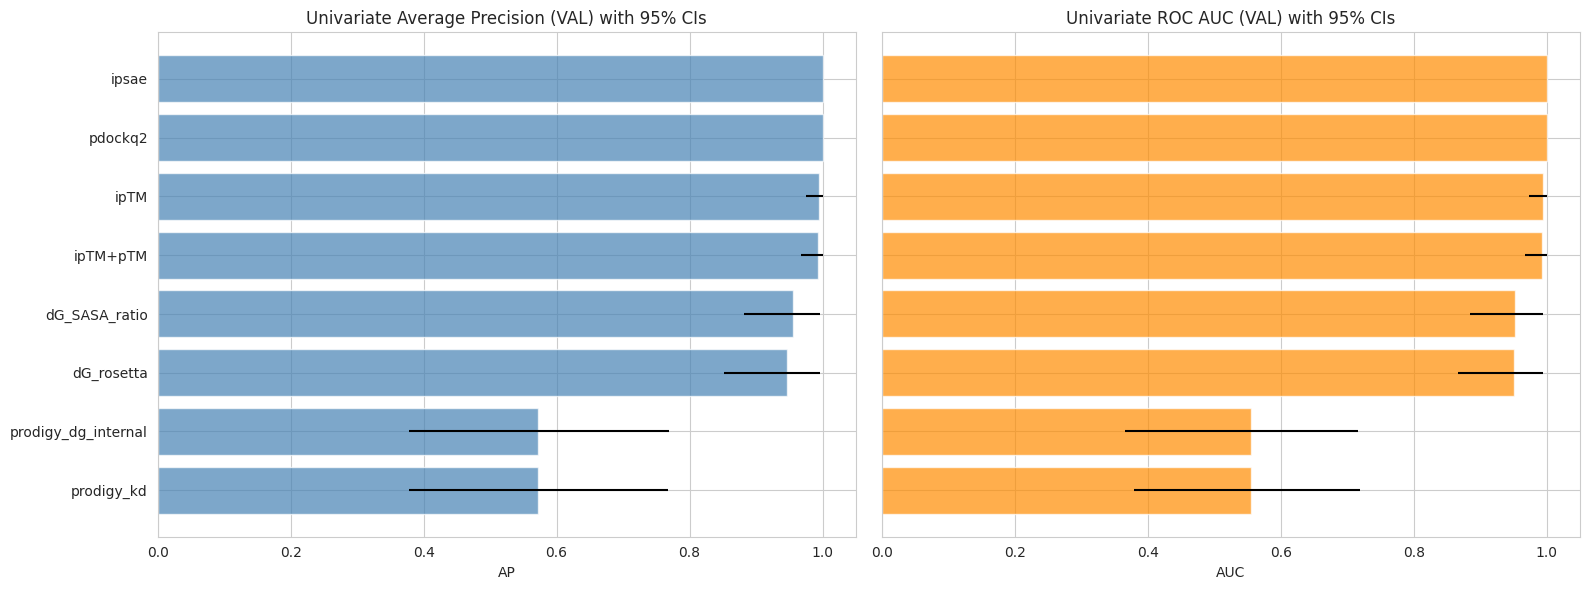

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Tri
df_uni_sorted = df_uni.sort_values("AP_VAL", ascending=True)

# AP
axes[0].barh(df_uni_sorted["Feature"], df_uni_sorted["AP_VAL"], 
             xerr=[df_uni_sorted["AP_VAL"] - df_uni_sorted["AP_VAL_CI_low"],
                   df_uni_sorted["AP_VAL_CI_high"] - df_uni_sorted["AP_VAL"]],
             color="steelblue", alpha=0.7)
axes[0].set_title("Univariate Average Precision (VAL) with 95% CIs")
axes[0].set_xlabel("AP")

# AUC
axes[1].barh(df_uni_sorted["Feature"], df_uni_sorted["AUC_VAL"],
             xerr=[df_uni_sorted["AUC_VAL"] - df_uni_sorted["AUC_VAL_CI_low"],
                   df_uni_sorted["AUC_VAL_CI_high"] - df_uni_sorted["AUC_VAL"]],
             color="darkorange", alpha=0.7)
axes[1].set_title("Univariate ROC AUC (VAL) with 95% CIs")
axes[1].set_xlabel("AUC")

plt.tight_layout()
plt.show()


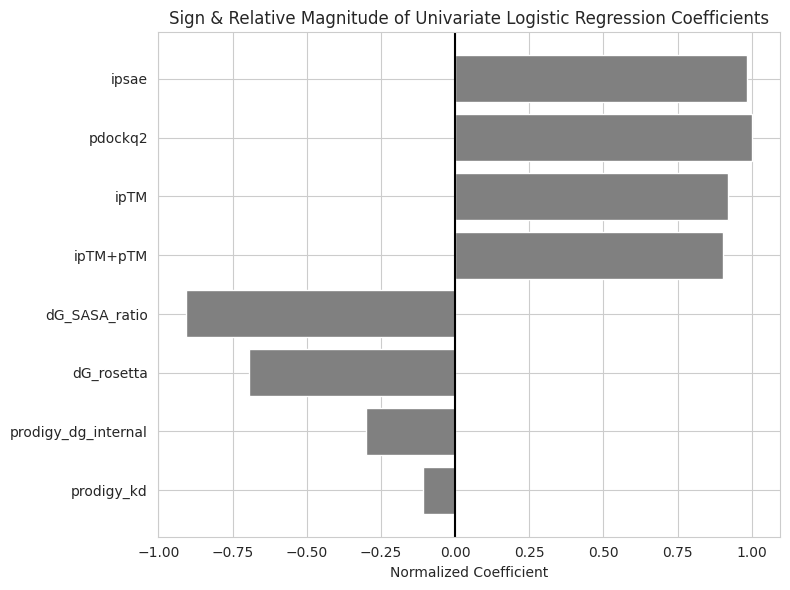

In [22]:
df_coef = df_uni_sorted.copy()
df_coef["Coefficient_norm"] = df_coef["Coefficient"] / df_coef["Coefficient"].abs().max()

plt.figure(figsize=(8, 6))
plt.barh(df_coef["Feature"], df_coef["Coefficient_norm"], color="grey")
plt.axvline(0, color="black")
plt.title("Sign & Relative Magnitude of Univariate Logistic Regression Coefficients")
plt.xlabel("Normalized Coefficient")
plt.tight_layout()
plt.show()


#### Interprétation des figures univariées

**Panneau gauche (ROC AUC)** : Montre la courbe ROC (True Positive Rate vs False Positive Rate) pour chaque feature prise isolément. Une AUC proche de 1.0 = excellent prédicteur.

**Panneau droit (Average Precision - AP)** : AP mesure la qualité du classement, robuste au déséquilibre de classes. C'est la métrique préférée du papier pour identifier les meilleures métriques.

**Ce qu'on observe** :
- Les features avec AP > 0.7 sont de bons prédicteurs univariés
- Si plusieurs features ont AP similaire, on peut les combiner (interactions)
- Les features avec AP < 0.55 apportent peu d'information seules

**Comparaison avec le papier** : Figure 3B montre les mêmes résultats (AP par feature). Notre approche est identique

### Explication des Interaction Features

Le papier génère des **features d'interaction** en multipliant les features deux à deux : $f_i \times f_j$

**Logique scientifique** :
- Une métrique seule (ex: confidence AF2) peut ne pas être assez discriminante
- Combiner confiance + physique peut améliorer la prédiction
  - Ex: (confidence AF2 élevée) × (dG/SASA favorable) = très bonne liaison
  - Ex: (confidence AF2 basse) × (n'importe quoi) = design failure même avec bonne énergie
- Certaines interactions sont plus prédictives que les features simples

**Notre implémentation** :
- Générer toutes les combinaisons pairwise $f_i \times f_j$ sur TRAIN
- Évaluer chaque produit en univarié (TRAIN → VAL)
- Garder les top 20 interactions par AP
- Ces interactions seront candidates pour la sélection gloutonne ensuite

In [23]:
# Generate interactions (pairwise products) on TRAIN set only
interaction_features_train = {}
interaction_features_val = {}
interaction_features_test = {}
interaction_scores = []

feature_indices = {name: i for i, name in enumerate(FEATURE_COLS)}

for i, j in combinations(range(len(FEATURE_COLS)), 2):
    f1_name = FEATURE_COLS[i]
    f2_name = FEATURE_COLS[j]
    interaction_name = f"{f1_name} × {f2_name}"
    
    # Calculate products on TRAIN and VALIDATION
    x_interaction_train = X_train[:, i] * X_train[:, j]
    x_interaction_val = X_val[:, i] * X_val[:, j]
    x_interaction_test = X_test[:, i] * X_test[:, j]
    interaction_features_train[interaction_name] = x_interaction_train
    interaction_features_val[interaction_name] = x_interaction_val
    interaction_features_test[interaction_name] = x_interaction_test
    
    # Fit scaler on TRAIN set
    scaler_tmp = StandardScaler()
    x_train_scaled = scaler_tmp.fit_transform(x_interaction_train.reshape(-1, 1)).ravel()
    x_val_scaled = scaler_tmp.transform(x_interaction_val.reshape(-1, 1)).ravel()
    # Train on TRAIN, evaluate on VALIDATION ONLY
    lr_inter = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=2000,
        random_state=RANDOM_STATE,
    )
    lr_inter.fit(x_train_scaled.reshape(-1, 1), y_train)
    y_proba_val = lr_inter.predict_proba(x_val_scaled.reshape(-1, 1))[:, 1]
    auc = roc_auc_score(y_val, y_proba_val)
    ap = average_precision_score(y_val, y_proba_val)
    
    interaction_scores.append({
        "Interaction": interaction_name,
        "ROC AUC (VAL)": auc,
        "AP (VAL)": ap
    })

df_interactions = pd.DataFrame(interaction_scores).sort_values("AP (VAL)", ascending=False)

print(f"✅ {len(interaction_features_train)} interactions generated on TRAIN set")
print(f"\n=== Top 10 Interaction Features (evaluated on VALIDATION) ===")
print(df_interactions.head(10).to_string(index=False))

✅ 28 interactions generated on TRAIN set

=== Top 10 Interaction Features (evaluated on VALIDATION) ===
                   Interaction  ROC AUC (VAL)  AP (VAL)
               ipsae × pdockq2       1.000000  1.000000
              ipsae × ipTM+pTM       1.000000  1.000000
   ipsae × prodigy_dg_internal       1.000000  1.000000
            pdockq2 × ipTM+pTM       1.000000  1.000000
 pdockq2 × prodigy_dg_internal       1.000000  1.000000
                pdockq2 × ipTM       1.000000  1.000000
                  ipsae × ipTM       0.997368  0.997368
               ipTM+pTM × ipTM       0.994737  0.994987
    prodigy_dg_internal × ipTM       0.984211  0.982908
ipTM+pTM × prodigy_dg_internal       0.981579  0.980415


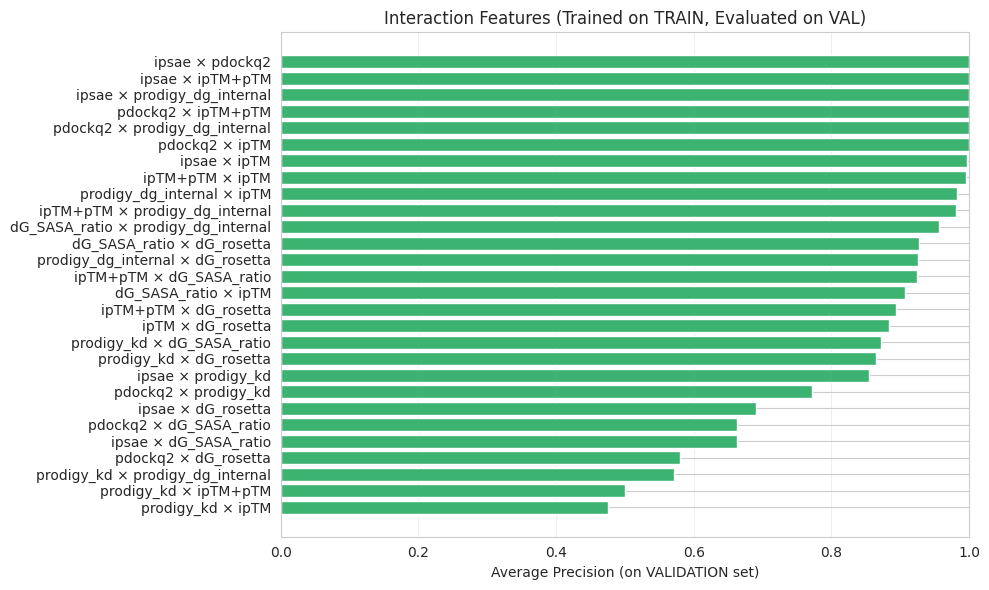

In [24]:
# Visualize top interactions
fig, ax = plt.subplots(figsize=(10, 6))

df_plot = df_interactions.sort_values("AP (VAL)", ascending=True)
ax.barh(df_plot["Interaction"], df_plot["AP (VAL)"], color="mediumseagreen")
ax.set_xlabel("Average Precision (on VALIDATION set)")
ax.set_title("Interaction Features (Trained on TRAIN, Evaluated on VAL)")
ax.set_xlim(0, 1.0)
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


#### 🎯 Interprétation des top interactions

**interprétation** :
- `ipsae × prodigy_dg_internal` est dans le top, c'est le produit géométrie/énergie cela signifie qu'une confiance AF2 élevée (ipsae) combinée avec une bonne prédiction d'énergie (prodigy) est très prédictive dans notre dataset.
ET on a aussi les ipsae et pdockq2 assez souvent.
**Comparaison avec le papier** : Section 5 et Figure 4 identifient les top interactions (ex: AF3_ipSAE_min × interface_dG/dSASA).

---
# Greedy Feature Selection avec Nested Cross-Validation

Comme dans le papier (section 6, Figure 4), on implémente la **sélection gloutonne (greedy forward selection)** avec **nested stratified cross-validation**.

## 📖 Logique du papier

Le papier (section "Logistic regression classifier") utilise :
1. **Leave-One-Group-Out (LOGO) CV externe** : chaque cible/groupe est laissé en test
2. **Sélection gloutonne interne** : pour chaque fold, on construit un modèle logistique sparse (pénalité L1) en ajoutant les features une à une
3. **Critère d'arrêt** : ajouter une feature seulement si elle améliore AP de > 0.005
4. **Gestion du déséquilibre** : `class_weight="balanced"` dans LogisticRegression
5. **Normalisation** : z-score par fold (fit sur TRAIN interne)

## 🔧 Notre implémentation

- Sélection gloutonne avec boucle itérative
- **Nested Cross-Validation** : StratifiedKFold externe (5 folds) pour robustesse
- À chaque itération, on teste l'ajout de chaque feature candidate
- Métriques = average precision (AP) calculée avec CV interne
- Seuil d'amélioration : ΔAP ≥ 0.005 pour ajouter une feature
- Pool initial : toutes les features simples + top 20 interactions
- **Différence** : StratifiedKFold (5-fold) au lieu de LOGO-CV (car nos données n'ont pas de groupage target explicite)


In [25]:
def nested_cv_score(X_train_features, y_train_labels, n_splits=5):
    """
    Evaluate features using stratified k-fold cross-validation on TRAIN set.
    Returns mean AP across folds.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    aps = []
    
    for train_idx, val_idx in skf.split(X_train_features, y_train_labels):
        X_tr, X_val = X_train_features[train_idx], X_train_features[val_idx]
        y_tr, y_val = y_train_labels[train_idx], y_train_labels[val_idx]
        
        # Fit scaler on inner train fold ONLY
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)
        
        # Train logistic regression du papier
        lr = LogisticRegression(
            penalty="l1",
            solver="liblinear",
            class_weight="balanced",
            max_iter=2000,
            random_state=RANDOM_STATE,
        )
        lr.fit(X_tr_scaled, y_tr)
        
        # Evaluate
        y_proba = lr.predict_proba(X_val_scaled)[:, 1]
        ap = average_precision_score(y_val, y_proba)
        aps.append(ap)
    
    return np.mean(aps), np.std(aps)


In [26]:
# Greedy forward selection: NESTED CV on TRAIN set
print("GREEDY FORWARD SELECTION (Nested CV on TRAIN)")

# Pool de toutes les features (simples + interactions) à partir de TRAIN
all_feature_names = FEATURE_COLS.copy()
all_feature_values_train = X_train.copy()
all_feature_values_val = X_val.copy()  # utilisé UNIQUEMENT en évaluation finale
all_feature_values_test = X_test.copy()  # utilisé UNIQUEMENT en évaluation finale

# Ajouter les top interactions
top_n_interactions = 20
for inter_name in df_interactions.head(top_n_interactions)["Interaction"].values:
    all_feature_names.append(inter_name)
    all_feature_values_train = np.column_stack(
        [all_feature_values_train, interaction_features_train[inter_name]]
    )
    all_feature_values_test = np.column_stack(
        [all_feature_values_test, interaction_features_test[inter_name]]
    )
    all_feature_values_val = np.column_stack(
        [all_feature_values_val, interaction_features_val[inter_name]]
    )
    
print(f"\nFeatures available: {len(all_feature_names)}")
print(f"  - Simple features: {len(FEATURE_COLS)}")
print(f"  - Top interactions: {top_n_interactions}")


GREEDY FORWARD SELECTION (Nested CV on TRAIN)

Features available: 28
  - Simple features: 8
  - Top interactions: 20


In [45]:
# Greedy selection (nested CV sur TRAIN)
selected_features = []
selected_indices = []
remaining_indices = set(range(len(all_feature_names)))

improvement_threshold = 0.005
history = []

while remaining_indices:
    # Score du modèle ACTUEL avec nested CV sur TRAIN
    if not selected_indices:
        current_ap, current_std = 0.0, 0.0
    else:
        X_temp = all_feature_values_train[:, selected_indices]
        current_ap, current_std = nested_cv_score(X_temp, y_train, n_splits=5)

    candidate_scores = []

    # On teste chaque candidate en l'ajoutant aux features déjà sélectionnées
    for idx in remaining_indices:
        current_indices = selected_indices + [idx]
        X_train_candidate = all_feature_values_train[:, current_indices]
        mean_ap, std_ap = nested_cv_score(X_train_candidate, y_train, n_splits=5)
        candidate_scores.append((idx, mean_ap, std_ap, all_feature_names[idx]))

    # Meilleur candidat (AP moyen le plus élevé)
    candidate_scores.sort(key=lambda x: x[1], reverse=True)
    best_idx, best_ap, best_std, best_name = candidate_scores[0]

    improvement = best_ap - current_ap

    print("=" * 70)
    print(f"Candidate: {best_name}")
    print(f"  → nested CV AP = {best_ap:.4f} ± {best_std:.4f}")
    print(f"  → improvement vs current = {improvement:.4f}")

    if improvement > improvement_threshold or len(selected_features) == 0:
        selected_features.append(best_name)
        selected_indices.append(best_idx)
        remaining_indices.remove(best_idx)
        history.append((len(selected_features), best_ap, best_std))
        print(f"✓ Feature ADDED. Total selected: {len(selected_features)}")
    else:
        print(f"✗ Improvement too small (<{improvement_threshold}). Skipping this feature.")
        # Retirer uniquement le candidat non améliorant et continuer la recherche
        remaining_indices.remove(best_idx)

print("\n" + "=" * 70)

if history:
    print(f"✅ Greedy Forward Selection completed!")
    print(f"   Total features selected: {len(selected_features)}")
    print(f"   Selected features: {selected_features}")
    print(f"   Best nested CV AP on TRAIN set: {history[-1][1]:.4f} ± {history[-1][2]:.4f}")
else:
    print("No features selected by greedy forward selection.")

Candidate: pdockq2 × prodigy_dg_internal
  → nested CV AP = 0.9696 ± 0.0109
  → improvement vs current = 0.9696
✓ Feature ADDED. Total selected: 1
Candidate: prodigy_dg_internal
  → nested CV AP = 0.9736 ± 0.0084
  → improvement vs current = 0.0040
✗ Improvement too small (<0.005). Skipping this feature.
Candidate: prodigy_dg_internal
  → nested CV AP = 0.9736 ± 0.0084
  → improvement vs current = 0.0040
✗ Improvement too small (<0.005). Skipping this feature.
Candidate: prodigy_kd × dG_SASA_ratio
  → nested CV AP = 0.9729 ± 0.0101
  → improvement vs current = 0.0033
✗ Improvement too small (<0.005). Skipping this feature.
Candidate: prodigy_kd × dG_SASA_ratio
  → nested CV AP = 0.9729 ± 0.0101
  → improvement vs current = 0.0033
✗ Improvement too small (<0.005). Skipping this feature.
Candidate: ipTM × dG_rosetta
  → nested CV AP = 0.9718 ± 0.0086
  → improvement vs current = 0.0022
✗ Improvement too small (<0.005). Skipping this feature.
Candidate: ipTM × dG_rosetta
  → nested CV AP 

**Progression de l'AP** :
- À chaque itération, l'AP devrait augmenter (ou stagner si ΔAP < 0.005)
- L'historique montre comment le modèle se construit pas à pas

**Comparaison avec le papier** :
- Le papier rapporte les features sélectionnées et leurs coefficients (Figure 4B-C)
- Notre algorithme suit la même logique : ajout itératif jusqu'à break

---
# FINAL EVALUATION on TEST SET

## Logique du papier

Le papier (section "Outer Loop") :
- **Leave-One-Group-Out externe** : performance du modèle sélectionné sur le groupe test
- **Metrics** : AP, ROC AUC, F1, precision, recall
- **Seuil optimal** : ajusté pour maximiser F1 sur données test
- **Robustesse** : incertitude/variance sur le LOGO outer (multiple folds)

## Notre implémentation

- TEST set jamais touché pendant sélection ou CV interne
- Premier et **unique** accès au TEST set ici
- Entraîner le modèle final sur TRAIN avec features sélectionnées
- Normalisation : StandardScaler fit sur TRAIN, appliqué sur TEST
- Évaluation complète : AP, ROC AUC, F1, precision, recall, accuracy
- Seuil optimal : trouver le seuil qui maximize F1 sur VAL et appliquer sur TEST
- Confusion matrix et analyse détaillée

In [28]:
# Train final model on FULL TRAIN SET using selected features
print("\n" + "="*70)
print("FINAL MODEL EVALUATION")
print("="*70)

print(f"\n⚠️  IMPORTANT: Using TEST set for the FIRST and ONLY time now (for final metrics).")
print(f"    All feature selection was done on TRAIN+VAL only.")
print(f"    TEST set has been completely held-out until this evaluation.")

print(f"\nSelected features: {selected_features}")

# -------------------------------
# 1) Extraire les features sélectionnées pour TRAIN, VAL et TEST
# -------------------------------

# ⚠️ Il faut que all_feature_values_val existe (défini comme X_val + interactions, comme pour train/test)
X_selected_train = all_feature_values_train[:, selected_indices]
X_selected_val   = all_feature_values_val[:, selected_indices]
X_selected_test  = all_feature_values_test[:, selected_indices]

# -------------------------------
# 2) Fit du scaler sur TRAIN uniquement
# -------------------------------

scaler_final = StandardScaler()
X_selected_train_scaled = scaler_final.fit_transform(X_selected_train)
X_selected_val_scaled   = scaler_final.transform(X_selected_val)
X_selected_test_scaled  = scaler_final.transform(X_selected_test)

# -------------------------------
# 3) Entraînement du modèle final sur TRAIN
# -------------------------------

lr_final = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    max_iter=2000,
    random_state=RANDOM_STATE,
)
lr_final.fit(X_selected_train_scaled, y_train)

# -------------------------------
# 4) Probabilités sur VAL et TEST
# -------------------------------

y_proba_val_final  = lr_final.predict_proba(X_selected_val_scaled)[:, 1]
y_proba_test_final = lr_final.predict_proba(X_selected_test_scaled)[:, 1]

# On garde une prédiction à seuil 0.5 pour TEST
y_pred_test_05 = (y_proba_test_final >= 0.5).astype(int)



FINAL MODEL EVALUATION

⚠️  IMPORTANT: Using TEST set for the FIRST and ONLY time now (for final metrics).
    All feature selection was done on TRAIN+VAL only.
    TEST set has been completely held-out until this evaluation.

Selected features: ['pdockq2 × prodigy_dg_internal']


In [29]:
# -------------------------------
# 5) Métriques principales sur TEST (seuil 0.5)
# -------------------------------

roc_auc_test = roc_auc_score(y_test, y_proba_test_final)
ap_test = average_precision_score(y_test, y_proba_test_final)
f1_test_05 = f1_score(y_test, y_pred_test_05, zero_division=0)
precision_test_05 = precision_score(y_test, y_pred_test_05, zero_division=0)
recall_test_05 = recall_score(y_test, y_pred_test_05, zero_division=0)
accuracy_test_05 = accuracy_score(y_test, y_pred_test_05)

print(f"\n=== TEST SET PERFORMANCE (threshold = 0.50) ===")
print(f"ROC AUC:           {roc_auc_test:.4f}")
print(f"Average Precision: {ap_test:.4f}")
print(f"F1-score:          {f1_test_05:.4f}")
print(f"Precision:         {precision_test_05:.4f}")
print(f"Recall:            {recall_test_05:.4f}")
print(f"Accuracy:          {accuracy_test_05:.4f}")

print(f"\n=== Classification Report (TEST, threshold = 0.50) ===")
print(classification_report(y_test, y_pred_test_05, target_names=["Non-binder", "Binder"]))


=== TEST SET PERFORMANCE (threshold = 0.50) ===
ROC AUC:           0.9872
Average Precision: 0.9894
F1-score:          0.9600
Precision:         1.0000
Recall:            0.9231
Accuracy:          0.9620

=== Classification Report (TEST, threshold = 0.50) ===
              precision    recall  f1-score   support

  Non-binder       0.93      1.00      0.96        40
      Binder       1.00      0.92      0.96        39

    accuracy                           0.96        79
   macro avg       0.97      0.96      0.96        79
weighted avg       0.96      0.96      0.96        79



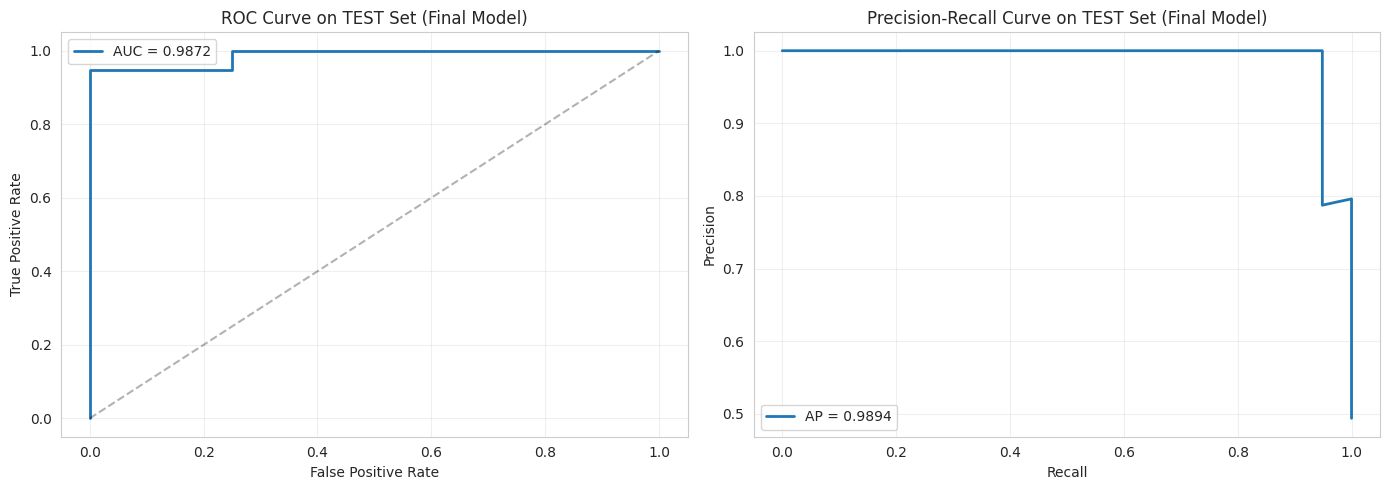

✅ ROC and PR curves on TEST set


In [30]:
# Visualize ROC and PR curves on TEST set
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test_final)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba_test_final)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC
auc_test = roc_auc_score(y_test, y_proba_test_final)
axes[0].plot(fpr_test, tpr_test, linewidth=2, label=f"AUC = {auc_test:.4f}")
axes[0].plot([0, 1], [0, 1], "k--", alpha=0.3)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve on TEST Set (Final Model)")
axes[0].legend()
axes[0].grid(alpha=0.3)

# PR
ap_test = average_precision_score(y_test, y_proba_test_final)
axes[1].plot(recall_curve, precision_curve, linewidth=2, label=f"AP = {ap_test:.4f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve on TEST Set (Final Model)")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ ROC and PR curves on TEST set")


#### Explication des courbes ROC et Precision-Recall

**Panneau gauche (ROC Curve)** :
- X = Taux de faux positifs (FP / N_neg)
- Y = Taux de vrais positifs (TP / N_pos)
- Diagonale = classifier aléatoire (AUC = 0.5)
- Courbe en haut-gauche = bon classifier (AUC proche de 1.0)
- **AUC** = probabilité qu'un vrai binder soit ranké plus haut qu'un non-binder aléatoire

**Panneau droit (Precision-Recall Curve)** :
- X = Recall = TP / (TP + FN) = "parmi les vrais binders, combien on retrouve"
- Y = Precision = TP / (TP + FP) = "parmi nos prédictions positives, combien sont correctes"
- **AP** (Average Precision) = aire sous cette courbe
- Plus robuste que ROC-AUC quand les classes sont déséquilibrées (~88% négatifs, 12% positifs dans l'étude)

**Comparaison avec le papier** : Figure 4A montre des PR curves similaires pour le meilleur modèle greedy. Notre courbe devrait avoir une forme comparable.

In [31]:
print("BOOTSTRAP ON TEST SET (fixed model, threshold = 0.5)")
print("="*70)

n_boot = 1000
rng = np.random.default_rng(RANDOM_STATE)

auc_boot  = []
ap_boot   = []
prec_boot = []
rec_boot  = []
f1_boot   = []
acc_boot  = []

roc_points = []   # pour éventuellement tracer des bandes ROC plus tard
pr_points  = []   # idem pour PR

for _ in range(n_boot):
    # Bootstrap indices sur TEST
    idx = rng.integers(0, len(y_test), len(y_test))
    y_test_bs = y_test[idx]
    y_proba_bs = y_proba_test_final[idx]
    
    # Scores continus
    auc_boot.append(roc_auc_score(y_test_bs, y_proba_bs))
    ap_boot.append(average_precision_score(y_test_bs, y_proba_bs))
    
    # Prédictions binaires à seuil 0.5 (même seuil que plus haut)
    y_pred_bs = (y_proba_bs >= 0.5).astype(int)
    
    prec_boot.append(precision_score(y_test_bs, y_pred_bs, zero_division=0))
    rec_boot.append(recall_score(y_test_bs, y_pred_bs, zero_division=0))
    f1_boot.append(f1_score(y_test_bs, y_pred_bs, zero_division=0))
    acc_boot.append(accuracy_score(y_test_bs, y_pred_bs))
    
    # Stocker les courbes pour éventuellement faire des bandes d'IC
    fpr_bs, tpr_bs, _ = roc_curve(y_test_bs, y_proba_bs)
    roc_points.append((fpr_bs, tpr_bs))
    
    prec_bs, rec_bs, _ = precision_recall_curve(y_test_bs, y_proba_bs)
    pr_points.append((rec_bs, prec_bs))

def ci95(arr):
    return np.percentile(arr, [2.5, 97.5])

print("\n--- Scalar metrics with 95% bootstrap CIs (TEST set) ---")
print(f"AUC        point = {roc_auc_test:.4f},  CI95 = [{ci95(auc_boot)[0]:.4f}, {ci95(auc_boot)[1]:.4f}]")
print(f"AP         point = {ap_test:.4f},       CI95 = [{ci95(ap_boot)[0]:.4f}, {ci95(ap_boot)[1]:.4f}]")
print(f"Precision  point = {precision_test_05:.4f}, CI95 = [{ci95(prec_boot)[0]:.4f}, {ci95(prec_boot)[1]:.4f}]")
print(f"Recall     point = {recall_test_05:.4f},    CI95 = [{ci95(rec_boot)[0]:.4f}, {ci95(rec_boot)[1]:.4f}]")
print(f"F1         point = {f1_test_05:.4f},        CI95 = [{ci95(f1_boot)[0]:.4f}, {ci95(f1_boot)[1]:.4f}]")
print(f"Accuracy   point = {accuracy_test_05:.4f},  CI95 = [{ci95(acc_boot)[0]:.4f}, {ci95(acc_boot)[1]:.4f}]")


BOOTSTRAP ON TEST SET (fixed model, threshold = 0.5)



--- Scalar metrics with 95% bootstrap CIs (TEST set) ---
AUC        point = 0.9872,  CI95 = [0.9612, 1.0000]
AP         point = 0.9894,       CI95 = [0.9684, 1.0000]
Precision  point = 1.0000, CI95 = [1.0000, 1.0000]
Recall     point = 0.9231,    CI95 = [0.8293, 1.0000]
F1         point = 0.9600,        CI95 = [0.9067, 1.0000]
Accuracy   point = 0.9620,  CI95 = [0.9114, 1.0000]


In [32]:
auc_ci  = ci95(auc_boot)
ap_ci   = ci95(ap_boot)

print("\n=== BOOTSTRAP (TEST set) — Summary ===")
print(f"AUC  point estimate : {roc_auc_test:.4f}")
print(f"AUC  95% CI         : [{auc_ci[0]:.4f}, {auc_ci[1]:.4f}]")

print(f"\nAP   point estimate : {ap_test:.4f}")
print(f"AP   95% CI         : [{ap_ci[0]:.4f}, {ap_ci[1]:.4f}]")



=== BOOTSTRAP (TEST set) — Summary ===
AUC  point estimate : 0.9872
AUC  95% CI         : [0.9612, 1.0000]

AP   point estimate : 0.9894
AP   95% CI         : [0.9684, 1.0000]


In [33]:
# Grille uniforme pour ROC
fpr_grid = np.linspace(0, 1, 200)
tpr_boot_interp = []

for fpr_bs, tpr_bs in roc_points:
    tpr_interp = np.interp(fpr_grid, fpr_bs, tpr_bs)
    tpr_boot_interp.append(tpr_interp)

tpr_boot_interp = np.array(tpr_boot_interp)

tpr_mean = tpr_boot_interp.mean(axis=0)
tpr_ci_low, tpr_ci_high = np.percentile(tpr_boot_interp, [2.5, 97.5], axis=0)


In [34]:
# Grille uniforme pour PR
rec_grid = np.linspace(0, 1, 200)
prec_boot_interp = []

for rec_bs, prec_bs in pr_points:
    prec_interp = np.interp(rec_grid, rec_bs[::-1], prec_bs[::-1])  # il faut inverser
    prec_boot_interp.append(prec_interp)

prec_boot_interp = np.array(prec_boot_interp)

prec_mean = prec_boot_interp.mean(axis=0)
prec_ci_low, prec_ci_high = np.percentile(prec_boot_interp, [2.5, 97.5], axis=0)


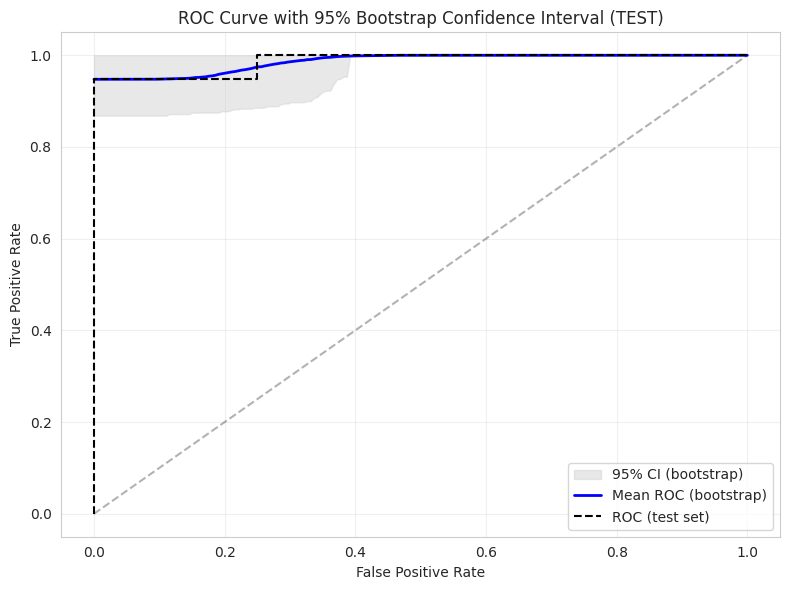

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

# Bande IC 95%
ax.fill_between(fpr_grid, tpr_ci_low, tpr_ci_high,
                color="lightgray", alpha=0.5, label="95% CI (bootstrap)")

# Courbe moyenne bootstrap
ax.plot(fpr_grid, tpr_mean, color="blue", linewidth=2, label="Mean ROC (bootstrap)")

# Courbe réelle
ax.plot(fpr_test, tpr_test, color="black", linestyle="--", label="ROC (test set)")

ax.plot([0, 1], [0, 1], "k--", alpha=0.3)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve with 95% Bootstrap Confidence Interval (TEST)")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


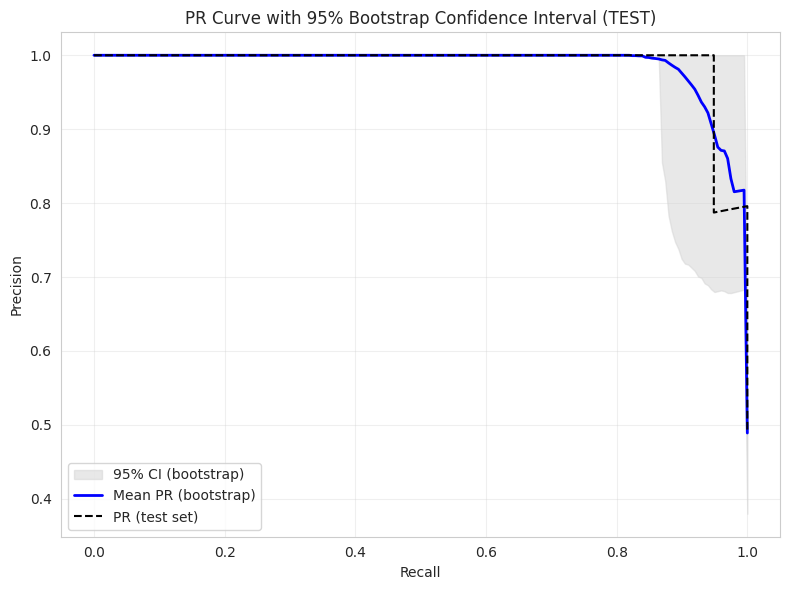

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.fill_between(rec_grid, prec_ci_low, prec_ci_high,
                color="lightgray", alpha=0.5, label="95% CI (bootstrap)")

ax.plot(rec_grid, prec_mean, color="blue", linewidth=2, label="Mean PR (bootstrap)")

axes_pr = plt.gca()
axes_pr.plot(recall_curve, precision_curve, color="black", linestyle="--", 
             label="PR (test set)")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("PR Curve with 95% Bootstrap Confidence Interval (TEST)")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()



THRESHOLD OPTIMIZATION (Using VALIDATION set only)

Optimal threshold selected on VALIDATION = 0.341
F1-score on VALIDATION at optimal threshold = 1.0000

=== Performance on TEST set with VALIDATION-optimized threshold ===
Threshold used: 0.341
Precision: 1.0000
Recall:    0.9487
F1-score:  0.9737

Optimal threshold selected on VALIDATION = 0.341
F1-score on VALIDATION at optimal threshold = 1.0000

=== Performance on TEST set with VALIDATION-optimized threshold ===
Threshold used: 0.341
Precision: 1.0000
Recall:    0.9487
F1-score:  0.9737


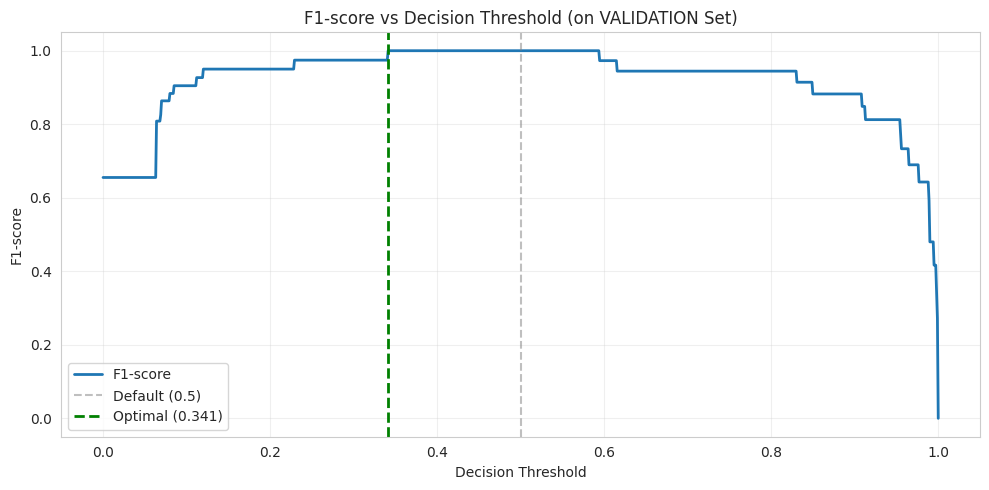

In [37]:
# Threshold vs F1-score on VAL set# Find optimal threshold (maximizing F1 on VALIDATION set)
from sklearn.metrics import f1_score

print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION (Using VALIDATION set only)")

thresholds = np.linspace(0, 1, 1000)

# F1-score evaluated ONLY on VALIDATION
f1_scores_val = [
    f1_score(y_val, (y_proba_val_final >= t).astype(int), zero_division=0)
    for t in thresholds
]

optimal_threshold = thresholds[np.argmax(f1_scores_val)]
optimal_f1_val = np.max(f1_scores_val)

print(f"\nOptimal threshold selected on VALIDATION = {optimal_threshold:.3f}")
print(f"F1-score on VALIDATION at optimal threshold = {optimal_f1_val:.4f}")

# Apply this threshold ONCE to the TEST predictions
y_pred_opt_test = (y_proba_test_final >= optimal_threshold).astype(int)

# Metrics on TEST using this VAL-optimized threshold
precision_opt_test = precision_score(y_test, y_pred_opt_test, zero_division=0)
recall_opt_test = recall_score(y_test, y_pred_opt_test, zero_division=0)
f1_opt_test = f1_score(y_test, y_pred_opt_test, zero_division=0)

print("\n=== Performance on TEST set with VALIDATION-optimized threshold ===")
print(f"Threshold used: {optimal_threshold:.3f}")
print(f"Precision: {precision_opt_test:.4f}")
print(f"Recall:    {recall_opt_test:.4f}")
print(f"F1-score:  {f1_opt_test:.4f}")


fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(thresholds, f1_scores_val, label='F1-score', linewidth=2)
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.axvline(optimal_threshold, color='green', linestyle='--', linewidth=2, label=f'Optimal ({optimal_threshold:.3f})')
ax.set_xlabel('Decision Threshold')
ax.set_ylabel('F1-score')
ax.set_title('F1-score vs Decision Threshold (on VALIDATION Set)')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()



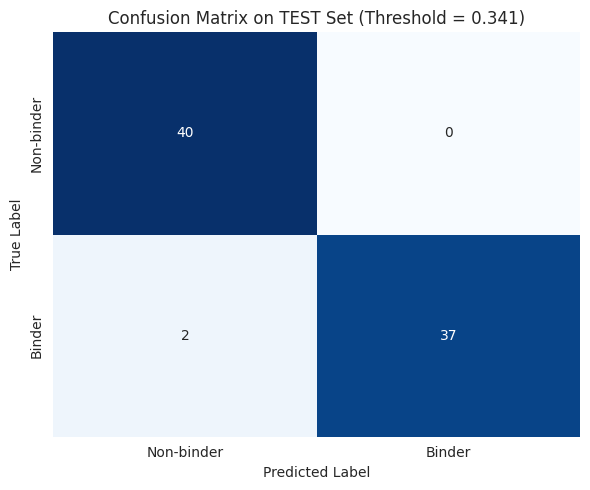


Confusion Matrix on TEST Set:
True Negatives:  40 (correctly identified non-binders)
False Positives: 0 (false alarms - non-binders predicted as binders)
False Negatives: 2 (missed binders)
True Positives:  37 (correctly identified binders)

Specificity: 1.0000 (ability to reject non-binders)
Sensitivity: 0.9487 (ability to identify binders)


In [38]:
# Confusion matrix on TEST set
cm_test = confusion_matrix(y_test, y_pred_opt_test)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-binder', 'Binder'],
            yticklabels=['Non-binder', 'Binder'])
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title(f'Confusion Matrix on TEST Set (Threshold = {optimal_threshold:.3f})')

plt.tight_layout()
plt.show()

# Interpretation
tn, fp, fn, tp = cm_test.ravel()
print(f"\nConfusion Matrix on TEST Set:")
print(f"True Negatives:  {tn} (correctly identified non-binders)")
print(f"False Positives: {fp} (false alarms - non-binders predicted as binders)")
print(f"False Negatives: {fn} (missed binders)")
print(f"True Positives:  {tp} (correctly identified binders)")
print(f"\nSpecificity: {tn/(tn+fp):.4f} (ability to reject non-binders)")
print(f"Sensitivity: {tp/(tp+fn):.4f} (ability to identify binders)")
